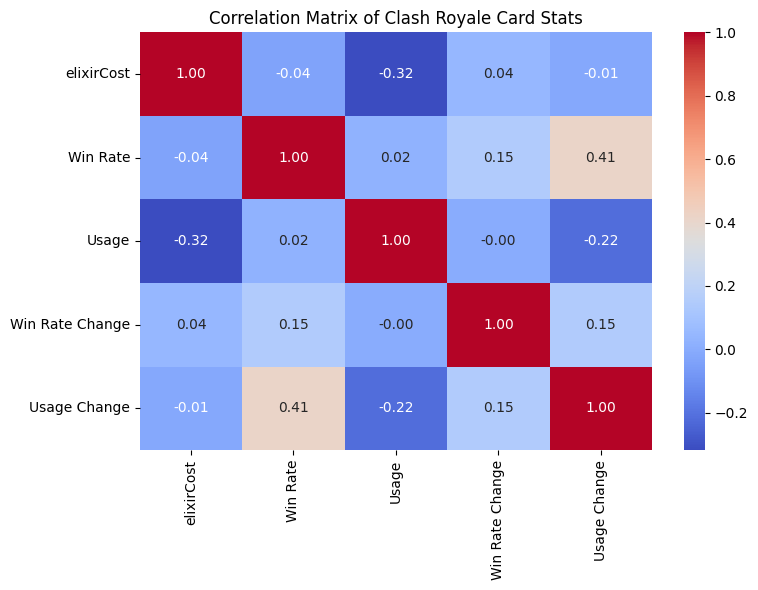

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Load 
df = pd.read_csv("clash_royale_cards.csv")  # Replace with your correct file path if needed

# Drop rows with missing values in relevant columns
df_clean = df.dropna(subset=['elixirCost', 'Win Rate', 'Usage', 'Win Rate Change', 'Usage Change'])

#Correlation Matrix Visualization

plt.figure(figsize=(8, 6))
sns.heatmap(df_clean[['elixirCost', 'Win Rate', 'Usage', 'Win Rate Change', 'Usage Change']].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Clash Royale Card Stats")
plt.tight_layout()
plt.show()



This heatmap shows how different stats are related like how closely win rate and usage go together. This gives us an idea on which variables to look at more closely.

We expected that popular cards probably win more, and that holds up. Some things to consider are that elixir cost doesn’t really link to win rate. So both cheap cycle cards and heavy tanks can be strong so it really depends on how you use them. Usage change and win rate change are also only loosely related, suggesting that card popularity can shift for reasons other than performance. This helped us pick the best stats for clustering and also gave us a feel for how balanced things different metrics of the game really are.

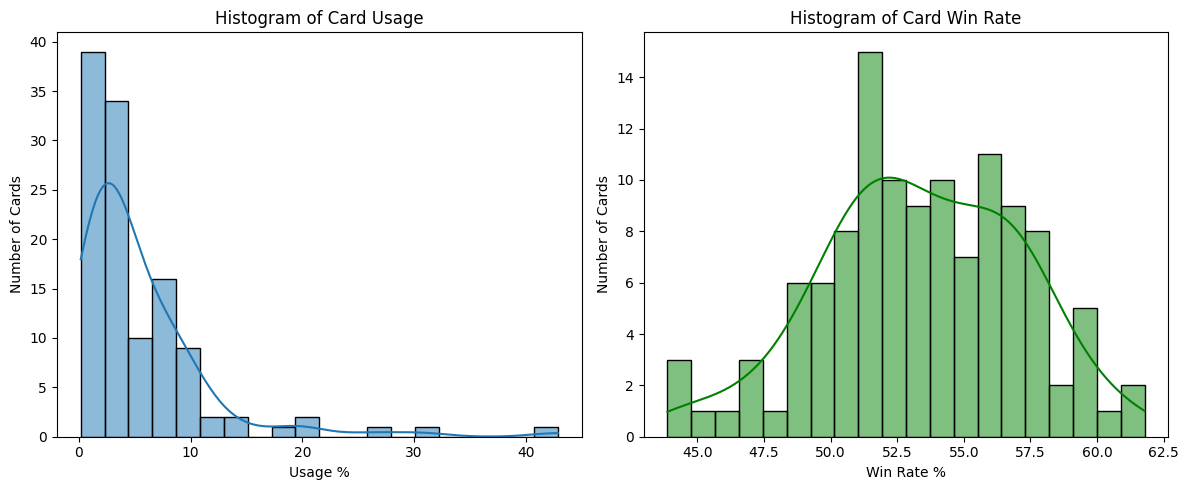

In [ ]:
plt.figure(figsize=(12, 5))

#Usage Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_clean['Usage'], bins=20, kde=True)
plt.title("Histogram of Card Usage")
plt.xlabel("Usage %")
plt.ylabel("Number of Cards")

#Win Rate Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_clean['Win Rate'], bins=20, kde=True, color='green')
plt.title("Histogram of Card Win Rate")
plt.xlabel("Win Rate %")
plt.ylabel("Number of Cards")

plt.tight_layout()
plt.show()

I wanted to see if the game is dominated by a couple cards and it looks like it is. Most cards are barely used and we can see this as the usage histogram drops off fast. That’s expected since the meta tends to concentrate around a core group of reliable cards. The win rate histogram is more evenly balances, which shows us that some lesser-used cards actually perform well when they’re played. There’s a gap between the cards being used and the cards that have potential to affect the game that are currently not used.

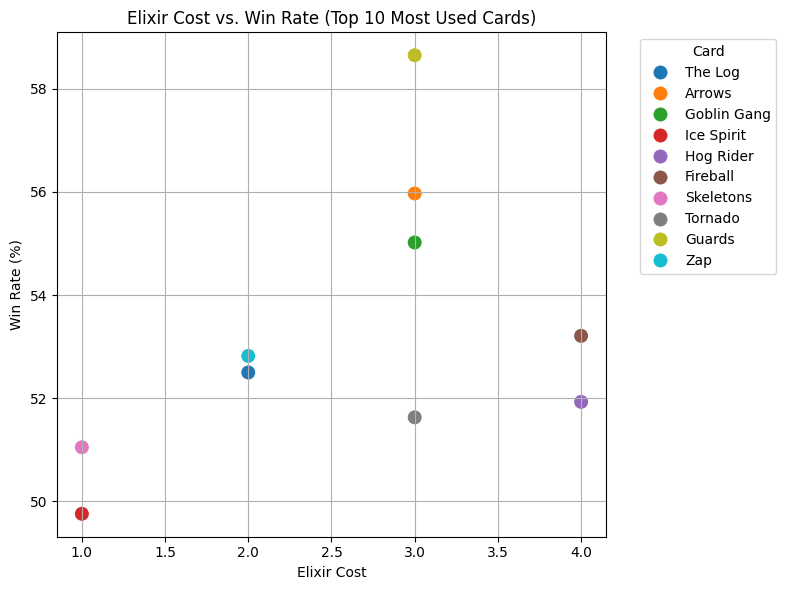

In [9]:
# Elixir Cost vs. Win Rate (Top 10 Most Used Cards)
top_used = df_clean.sort_values('Usage', ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=top_used, x='elixirCost', y='Win Rate', hue='Card', s=120)
plt.title("Elixir Cost vs. Win Rate (Top 10 Most Used Cards)")
plt.xlabel("Elixir Cost")
plt.ylabel("Win Rate (%)")
plt.legend(title="Card", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

This chart checks if the most played cards are actually good. Some are as they have high win rates and are probably reliable across a lot of decks. But a few are mediocre in terms of win rate, even though they’re played often. This is most likely due to familiarity or ease of use rather than actual efficieny of the card which is not surprising as people stick to what they are use to. This kind of plot helps separate statistically strong cards from ones that are just habitually used

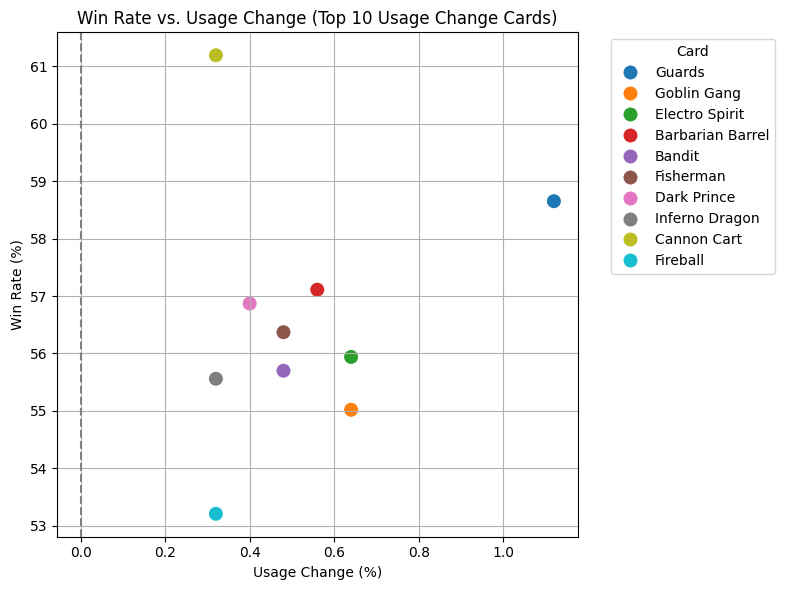

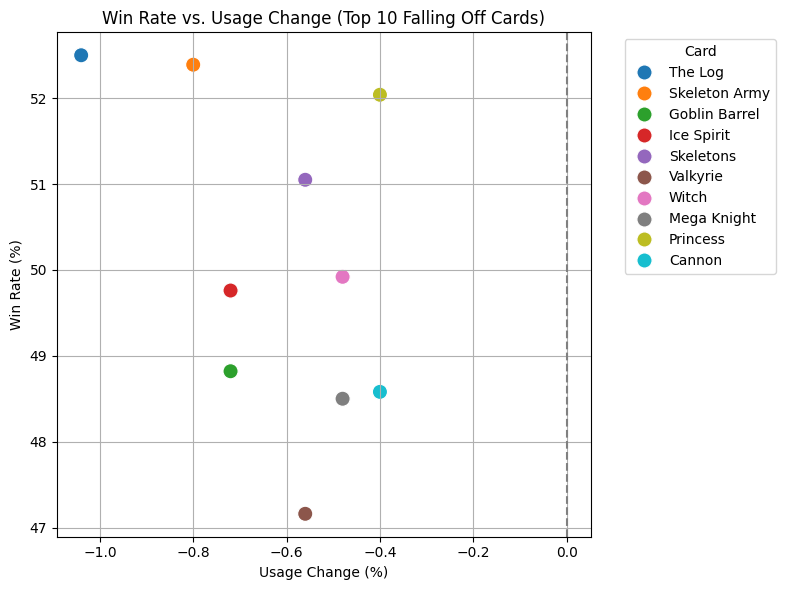

In [19]:
#Top 10 Cards by Highest Usage Change
top_usage_change_10 = df_clean.sort_values('Usage Change', ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=top_usage_change_10, x='Usage Change', y='Win Rate', hue='Card', s=120)
plt.axvline(0, linestyle='--', color='gray')  # reference line at 0
plt.title("Win Rate vs. Usage Change (Top 10 Usage Change Cards)")
plt.xlabel("Usage Change (%)")
plt.ylabel("Win Rate (%)")
plt.legend(title="Card", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Win Rate vs. Usage Change for Cards with Largest Negative Usage Change
falling_off_10 = df_clean.sort_values('Usage Change').head(10)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=falling_off_10, x='Usage Change', y='Win Rate', hue='Card', s=120)
plt.axvline(0, linestyle='--', color='gray')  # shows the 0 line
plt.title("Win Rate vs. Usage Change (Top 10 Falling Off Cards)")
plt.xlabel("Usage Change (%)")
plt.ylabel("Win Rate (%)")
plt.legend(title="Card", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



This one is useful for tracking shifts in the meta. Cards in the top right, which are increasing in usage and winning often, are clearly on the rise, either due to buffs or new strategies making them more viable. Cards to the left in the second graph shows 'fall-offs" which are cards that are decreasing in usage rate which also shows meta shifts. Then there are some that still win a lot but are dropping in usage, which could indicate players are moving away from them despite strong performanc, probably because they’re being countered more or have become predictable

In [20]:

#Load 
dataframe = pd.read_csv("clash_royale_cards.csv")

df = dataframe.copy()
# get rid of na values
df_clean = df.dropna(subset=['elixirCost', 'Win Rate', 'Usage', 'Win Rate Change', 'Usage Change'])

#Scale features
features = df_clean[['elixirCost', 'Win Rate', 'Usage', 'Win Rate Change', 'Usage Change']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

#K clustering graph
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean.loc[:, 'ClusterNum'] = kmeans.fit_predict(scaled_features)

#rename the clusters
# sort by avg win rate and usage
cluster_stats = df_clean.groupby('ClusterNum')[['Win Rate', 'Usage']].mean().sort_values(
    by=['Win Rate', 'Usage'], ascending=False
).reset_index()

#names based on rank
cluster_map = {
    cluster_stats.iloc[0]['ClusterNum']: 'High Win/High Usage',
    cluster_stats.iloc[1]['ClusterNum']: 'Mid Win/Mid Usage',
    cluster_stats.iloc[2]['ClusterNum']: 'Low Use Cards'
}
df_clean.loc[:, 'Cluster'] = df_clean['ClusterNum'].map(cluster_map)
# interactive part of the graph to see what card is what
fig = px.scatter(
    df_clean,
    x='elixirCost',
    y='Win Rate',
    color='Cluster',
    hover_data=['Card', 'elixirCost', 'Win Rate', 'Usage', 'Usage Change', 'Win Rate Change'],
    title="Clash Royale Cards: Elixir vs. Win Rate by K-Means Cluster",
    labels={'elixirCost': 'Elixir Cost', 'Win Rate': 'Win Rate (%)'},
    color_discrete_map={
        'High Win/High Usage': 'green',
        'Mid Win/Mid Usage': 'orange',
        'Low Use Cards': 'red'
    }
)

fig.update_traces(marker=dict(size=12, opacity=0.85, line=dict(width=1, color='black')))
fig.update_layout(legend_title_text='Cluster Group')
fig.show()


C:\Users\Nason\AppData\Local\Temp\ipykernel_83668\3316274702.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nason\AppData\Local\Temp\ipykernel_83668\3316274702.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



This chart groups cards into three categories: high win + high usage, mid-tier, and low-use cards. It’s basically a way to map out where each card stands in the current meta.

This allows us to quickly spot which cards are both strong and widely used (like go-to ladder staples), and which ones aren’t seeing play in the game. It also points out a few cards that win often but don’t get much love, poossibly underrated cards that could really contribute if more players used them.

In this kmeans graph, the biggest green cluster happens at around the 4-6 elixir mark which implies that many of the cards that contribute to winning are located within this cost range. 

## OVERALL FINDINGS

Top Overall cards

* Cannon Cart (Epic) – 61.19% win rate
* Lava Hound (Legendary) – 60.53% win rate

Across rarities, these are the highest-performing heavy cards (≥5 elixir):

* Epic: Cannon Cart – 61.19% win rate
* Legendary: Lava Hound – 60.53% win rate
* Rare: Elixir Collector – 59.31% (not an attacker, but a high-cost strategic card)
* Champion: Monk – 57.35%
* Common: Rascals – 56.92%

Cards like guards, electro spirit and barbarian barrel are on the rise and seem to be the new cards that are used after balance changes, while cards like valkeryie and goblin barrel are falling out of common decks


This project shows that while many popular cards are strong, there are several underused or rising cards that could disrupt the meta. KMeans clustering helped give us clear performance tiers, and usage trends revealed which cards are gaining traction and popularity or fading out. If you're trying to stick with the meta and its changes, cards like Cannon Cart and Lava Hound stand out as consistent performers, and keeping an eye on rising cards like Guards or Barb Barre; could help you adapt to the meta faster than most. While these graphs are not meant for you to just combine the highest use or highest win cards into one deck, it gives a clearer idea on which cards could help you succeed and which cards you should build your deck around. Good Luck.